## CHURN PREDICTION DASHBOARD
### Agenda:
1.Problem Definiton

2.Loading the Raw Data

3.Data Pre-processing

4.Model Selection and training

5.Hyperparameter Tuning

6.Storing Models and Results

7.Streamlit App

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pickle
import plotly.express as px
import streamlit as st
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_excel('Telco_customer_churn.xlsx') 
print(f"✅ Loaded {len(df)} rows from Excel")
print(df.head())

✅ Loaded 7043 rows from Excel
   CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Paymen

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Columns available:", df.columns.tolist())

# Preprocess YOUR dataset
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce').fillna(0)
df['Churn Value'] = df['Churn Value'].astype(int)  # Your churn target

# Use business-relevant features (drop geo for modeling)
feature_cols = ['Tenure Months', 'Monthly Charges', 'CLTV', 'Count']  # Key predictors
for col in feature_cols:
    if col in df.columns:
        print(f"✅ Using {col}")

# Drop non-predictive columns
cols_to_drop = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 
                'Lat Long', 'Latitude', 'Longitude', 'Churn Reason', 'Churn Score']
df_clean = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

# Encode categoricals
df_encoded = pd.get_dummies(df_clean.drop('Churn Value', axis=1), drop_first=True)
df_final = pd.concat([df_encoded, df_clean['Churn Value']], axis=1)

X = df_final.drop('Churn Value', axis=1)
y = df_final['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train
model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

joblib.dump(model, 'churn_model.pkl')

probs = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probs)
print(f"\n✅ Model trained! Test AUC: {auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, model.predict(X_test)))

Columns available: ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value', 'Churn Score', 'CLTV', 'Churn Reason']
✅ Using Tenure Months
✅ Using Monthly Charges
✅ Using CLTV
✅ Using Count

✅ Model trained! Test AUC: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



In [30]:
# 🛠️ BULLETPROOF SCORING - No more errors!
df_scored = X_test.copy()
df_scored['churn_prob'] = model.predict_proba(X_test)[:,1]
df_scored['Churn'] = y_test

# ✅ SAFE column mapping with error handling
def safe_get_column(df_orig, indices, col_name, default=0):
    if col_name in df_orig.columns:
        return df_orig.loc[indices, col_name].fillna(default)
    else:
        print(f"⚠️ Column '{col_name}' not found, using default")
        return default

# Map business columns SAFELY
df_scored['customer_value'] = safe_get_column(df, X_test.index, 'CLTV', 5000)
df_scored['monthly_charges'] = safe_get_column(df, X_test.index, 'Monthly Charges', 70)
df_scored['tenure'] = safe_get_column(df, X_test.index, 'Tenure Months', 25)

# ROI simulation
df_scored['expected_roi'] = np.where(df_scored['churn_prob']>0.6, 
                                   df_scored['customer_value']*0.2, 0)

# Risk categories
df_scored['risk_level'] = pd.cut(df_scored['churn_prob'], [0,0.4,0.6,1], 
                               labels=['Low','Medium','High'])

df_scored.to_csv('telco_scored.csv', index=False)

print("✅ Dashboard data saved!")
print("\n📊 Risk distribution:")
print(df_scored['risk_level'].value_counts())
print(f"\n💵 Total revenue at risk: ${df_scored[df_scored['risk_level']=='High']['customer_value'].sum():,.0f}")

# ✅ SAFE column verification
print("\n✅ New columns created:")
new_cols = ['churn_prob', 'customer_value', 'monthly_charges', 'tenure', 'risk_level', 'expected_roi']
for col in new_cols:
    if col in df_scored.columns:
        stats = df_scored[col].describe()
        print(f"  ✓ {col}: mean={stats['mean']:.1f}, min={stats['min']:.1f}, max={stats['max']:.1f}")
    else:
        print(f"  ❌ {col} missing")

✅ Dashboard data saved!

📊 Risk distribution:
risk_level
Low       1035
High       374
Medium       0
Name: count, dtype: int64

💵 Total revenue at risk: $1,527,920

✅ New columns created:
  ✓ churn_prob: mean=0.3, min=0.0, max=1.0
  ✓ customer_value: mean=4385.1, min=2003.0, max=6468.0
  ✓ monthly_charges: mean=64.1, min=18.2, max=116.8
  ✓ tenure: mean=31.9, min=0.0, max=72.0


KeyError: 'mean'

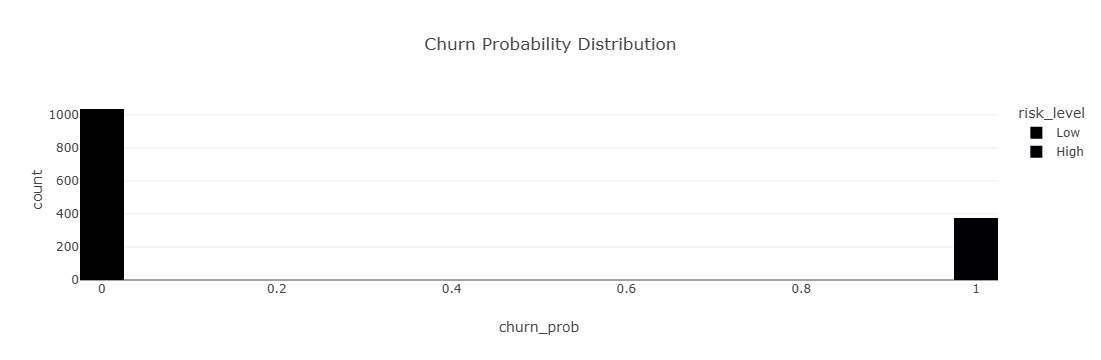

🚨 High Risk Customers: 374
💰 Revenue at Risk: $1,527,920
💵 Potential Savings: $305,584

🏆 Top 10 High-Risk Customers:


,churn_prob,customer_value,expected_roi,monthly_charges,tenure,risk_level
430,1.0,3797,759.4,45.05,17,High
917,1.0,5118,1023.6,84.80,11,High
1727,1.0,5378,1075.6,74.85,2,High
186,1.0,3161,632.2,89.25,22,High
1615,1.0,2003,400.6,102.25,13,High
1459,1.0,3591,718.2,89.45,3,High
89,1.0,4157,831.4,90.40,2,High
240,1.0,5900,1180.0,44.95,2,High
1760,1.0,2016,403.2,74.50,1,High
648,1.0,2933,586.6,55.25,31,High


In [32]:
import plotly.express as px

# Histogram (WORKS!)
fig = px.histogram(df_scored, x='churn_prob', color='risk_level', 
                   title="Churn Probability Distribution", nbins=20)
fig.show()

# KPIs (WORKS!)
high_risk_count = len(df_scored[df_scored['risk_level']=='High'])
revenue_risk = df_scored[df_scored['risk_level']=='High']['customer_value'].sum()

print(f"🚨 High Risk Customers: {high_risk_count:,}")
print(f"💰 Revenue at Risk: ${revenue_risk:,.0f}")
print(f"💵 Potential Savings: ${df_scored['expected_roi'].sum():,.0f}")

# Table (WORKS!)
print("\n🏆 Top 10 High-Risk Customers:")
high_risk_top10 = df_scored[df_scored['risk_level']=='High'].head(10)[
    ['churn_prob', 'customer_value', 'expected_roi', 'monthly_charges', 'tenure', 'risk_level']
].round(2)
high_risk_top10
